<a href="https://colab.research.google.com/github/alexjeong11/credit-card-fraud-detection/blob/master/project_jch_save.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 프로젝트 주제: 신용카드 사기 탐지
1. 배경  
![1](https://drive.google.com/uc?export=download&id=12v1CRZGbAJwlLJaOrTwMaHdNxor3cLzg)  ![2](https://drive.google.com/uc?export=download&id=1PPQznxOnPg2K_3nlnoMlxvdgzO4R1paX)  
분실. 도난 카드, 정보 도용을 통해 결제한 카드사기 규모가 지속적으로 증가 추세임.  
이에 효과 적인 대응하기 위한 기술 중 하나인 머신러닝을 이용하여 카드이용 패턴을 분석한 사기탐지(FDS)기술을 프로젝트 주제로 정하였음.
---
2. 데이터셋  
1) Kaggle 공개 데이터 활용:  
- Credit Card Fraud Detection(143.84 MB)  
2) 데이터 셋 설명  
- 2013 년 9 월 신용 카드로 유럽 카드 소지자가 수행한 거래 데이터로 2 일 동안 발생한 거래를 나타내며 전체 284,807 건의 데이터 중 492 건의 사기가 포함됨.  
- 데이터 세트의 불균형이 높으며 Fraud로 판별된 Class는 전체의 0.172 %를 차지함.  
- 데이터는 개인정보 보호문제로 PCA 변환을 적용하여 숫자 변수 만 포함됨.    
- 기능 V1, V2,... V28은 PCA로 얻은 구성 요소이며, “time”과 “amount” 데이터는 PCA 적용이 되지 않았음. “time”은 각 트랜잭션과 데이터 집합의 첫 번째 트랜잭션 사이에 경과 된 초가 포함,   'amount'기능은 거래 금액을 의미함,  
- Class는 Binary Classification으로 사기의 경우 값 1, 그렇지 않으면 0으로 구분됨  
예시)   
![3](https://drive.google.com/uc?export=download&id=1jdww--w_dmWqZ3cR6a_7iy5vqpZCyb80)
---
3. 데이터 전처리   
1) 전처리:  
- 데이터 중 값의 분포 범위가 넓은 amount, time 컬럼은 정규화를 통해 분포범위를 줄임.
2) 컬럼값 연관성 분석:  
- V1~V28 컬럼들과 결과 Class와 correlation분석을 통해 연관성이 떨어지는 데이터 컬럼을 제거 또는 값 범위를 축소 처리함.  
3) 학습 데이터 구성  
- 사기와 정상 데이터간 불균형(Imbalance)해소를 위해 언더샘플링과 오버샘플링을 수행하여 비교 
언더 샘플링 기법은 Random under sampling 사용  
오버 샘플링 기법은 SMOTE, GAN(생성적대적신경망)을 사용  
---
4. 분석 모델:   
1) 학습 알고리즘 
- 후보 알고리즘들을 적용하여 테스트 정확도를 비교하여 성능을 측정함. 
+ logistic regression
* Decision trees
* Random Forest
* SVM
* DNN  

2) 검증
k-fold cross-validation 기법을 적용하여 검증을 수행함.  

참고논문)
이용현, 구해모, 김형주. (2019). 오토인코더를 활용한 효율적인 신용카드 사기 탐지 지도 기 법. 정보과학회 컴퓨팅의 실제 논문지, 25(1), 1-8.
김예원, 유예림, 최홍용 (2020) 생성적 적대 신경망과 딥러닝을 활용한 이상거래탐지 시스템 모 형 ,Information Systems Review, 22:1, 59-72



* PCA 분석  
- 주성분 분석(PCA, Principal Component Analysis)은 가장 대표적인 차원 축소 알고리즘이며
PCA는 먼저 데이터에 가장 가까운 초평면(hyperplane)을 구한 다음, 데이터를 이 초평면에 투영(projection)시킨다.
1) 분산 보존
저차원의 초평면에 데이터를 투영하기 전에 먼저 적절한 초평면을 선택해야 한다. PCA는 데이터의 분산이 최대가 되는 축을 찾는다. 즉, 원본 데이터셋과 투영된 데이터셋 간의 평균제곱거리를 최소화 하는 축을 찾는다. 아래의 그림에서 왼쪽 2차원 데이터셋을 오른쪽 그림처럼 투영했을 때 ​축으로 투영한 데이터가 분산이 최대로 보존되는 것을 확인할 수 있다
![대체 텍스트](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile28.uf.tistory.com%2Fimage%2F99AC093E5B8A4904213CC3)  
2) 주성분 (Principal Component)
* PCA는 다음과 같은 단계로 이루어진다. 
1. 학습 데이터셋에서 분산이 최대인 축(axis)을 찾는다. 
2.이렇게 찾은 첫번째 축과 직교(orthogonal)하면서 분산이 최대인 두 번째 축을 찾는다.
3.첫 번째 축과 두 번째 축에 직교하고 분산을 최대한 보존하는 세 번째 축을 찾는다.
1~3과 같은 방법으로 데이터셋의 차원(특성 수)만큼의 축을 찾는다.
![대체 텍스트](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile6.uf.tistory.com%2Fimage%2F996F65335B8A493207D19B)  
이렇게 ​-번째 축을 정의하는 단위 벡터(unit vector)를 ​-번째 주성분(PC, Principal Component)이라고 한다.  
예를들어, 위의 그림에서는 2차원 데이터셋이므로 PCA는 분산을 최대로 보존하는 단위벡터 ​이 구성하는 축과 이 축에 직교하는 ​가 구성하는 축을 찾게 된다

출처: https://excelsior-cjh.tistory.com/167

In [20]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt  #statistical data visualization
import seaborn as sns # statistical data visualization
from sklearn.manifold import TSNE #t-distributed Stochastic Neighbor Embedding.
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches #2D artist with a face color and an edge color.
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets
from sklearn.pipeline import make_pipeline #Construct a Pipeline from the given estimators.
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

#goolge drive mount
from google.colab import drive
drive.mount('/content/gdrive')

#read from google drive
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/creditcard.csv')
#data sample
data.head()



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#data 정보 요약
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# null 항목값 조회
data.isnull().sum().max()

0

In [5]:
#컬럼 정보 조회
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

No Frauds 99.83 %
Frauds 0.17 %


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

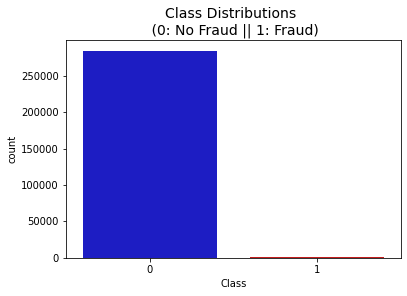

In [6]:
 # class별 데이터 비율 조회
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '%')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '%')

colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
 

* 데이터 대부분이 사기에 아닌 class에 속해 있어 학습과정에서 원본을 그대로 사용할 경우 overfitting, 및 데이터 항목간 correlation  문제 발생가능성이 있음. 
* amount, time항목은 분포가 불규칙하여 scaling이 필요함.

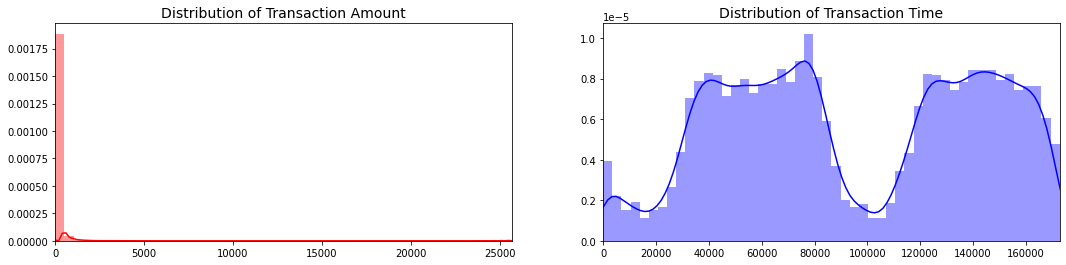

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

* amount, time 항목 값 scaling
* 기존 mean을 제거하고 IQR(25~75%)범위로 데이터 값을 변환함


In [0]:
# removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range).
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

#Fit to data, then transform it.
data['scaled_amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

* scaling 값 출력

In [9]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)

data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Sub-sampling
모델학습의 정확도를 위해 Fraud, non-fraud 데이터 비율을 5:5로 설정함
* Fraud 데이터 수가 적어 학습 후 모델의 성능 판별이 어려워 짐. <br>  (accuracy는 높아지나 Fraud 클래스의 recall은 급격하게 낮아짐)
* 클래스별 데이터 수의 비대칭 문제를 해결하기 위해 다수 클래스 데이터에서 일부만 사용하는 under sampling이나 소수 클래스 데이터를 증가시키는 over sampling을 적용함.
* 먼저 Random under sampling 적용을 위해 원본 데이터에서 테스트용 데이터 셋을  분할함.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

#label 분리 저장
x = data.drop('Class', axis=1)
y = data['Class']

#Stratified K-Folds cross-validator Provides train/test indices to split data in train/test sets.
#Generate test sets such that all contain the same distribution of classes
s_data = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in s_data.split(x, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = x.iloc[train_index], x.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# iloc Purely integer-location based indexing for selection by position.

#list value save
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values



No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


## Random Under-Sampling  
Fraud 데이터 수 492개의 건수 만큼 non-Fraud 데이수를 맞춰 5:5 비율로 데이터를 준비하고  무작위로 데이터를 섞어 학습 수행함.




In [11]:
#Return a random sample of items from an axis of object, Fraction of axis items to return
data = data.sample(frac=1)

fraud_df = data.loc[data['Class'] == 1]
non_fraud_df = data.loc[data['Class'] == 0][:492]

#Concatenate pandas objects along a particular axis with optional set logic along the other axes.
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

#random_state Seed for the random number generator 
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
56295,0.083700,-0.438656,1.133266,-0.388979,1.012288,0.282403,-1.147689,-0.335364,-0.626664,0.128546,0.691849,-0.124945,1.119866,0.949549,-0.444623,-0.083487,-0.545990,0.180700,-0.189098,0.148336,0.348304,-0.052503,0.107948,0.434859,-0.074979,0.631174,0.275711,1.120815,-0.053829,0.003495,0
123301,-0.293440,-0.091824,-1.298359,1.079671,-0.180678,1.287839,1.858273,-2.223695,0.525167,-0.096874,-0.168893,-2.544410,0.707000,-0.835696,-1.022117,-4.993992,-0.455707,1.315365,3.639200,1.623426,-1.539339,-0.187572,-0.332983,-0.851270,-0.370800,0.298242,0.442930,-0.522832,0.000105,0.135698,1
49989,2.109970,-0.474630,-0.831199,0.765118,0.645460,0.426824,0.257747,0.117694,1.975706,-0.664110,-0.313365,0.680774,1.292197,-0.433917,-1.823945,0.441026,0.210285,-0.433214,-0.496548,-0.038238,-0.186035,-0.450940,0.054810,0.613054,-0.225288,0.000066,-0.456048,-0.498755,-0.533759,-0.337522,0
4920,3.045204,-0.942563,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1
15225,1.089779,-0.682656,-19.856322,12.095893,-22.464083,6.115541,-15.148022,-4.346724,-15.648507,13.276805,-3.974162,-8.859194,5.730816,-8.088034,0.230825,-8.578973,0.000947,-6.947746,-13.472897,-4.940211,1.230143,1.582930,1.750730,-1.409636,-0.809809,0.121397,1.350300,-0.224292,1.597621,0.476920,1


* 균일하게 샘플링 되었는지 class 비율 확인

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


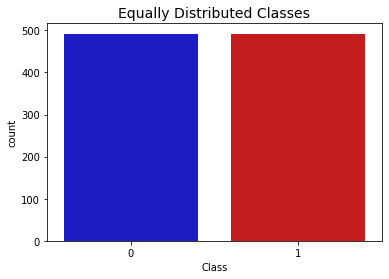

In [12]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Correlation analysis
- 두 변수간에 어떤 선형적 또는 비선형적 관계를 갖고 있는 지를 분석하는 방법
- 변수는 서로 독립적인 관계이거나 상관된 관계일 수 있으며 이때 두 변수간의 관계의 강도를 상관관계(Correlation, Correlation coefficient)라 한다. 
- 상관분석에서는 상관관계의 정도를 나타내는 단위로 모상관계수로 ρ를 사용하며 표본 상관 계수로 r 을 사용
- 상관관계의 정도를 파악하는 상관 계수(相關係數, Correlation coefficient)는 두 변수간의 연관된 정도를 나타낼 뿐 인과관계를 설명하는 것은 아님. 
- 두 변수간에 원인과 결과의 인과관계가 있는지에 대한 것은 회귀분석을 통해 인과관계의 방향, 정도와 수학적 모델을 확인해 볼 수 있음  
출처) wikipedia

* 추출된 데이터의 각 항목이 분류된 클래스와 어떤 관계인지 분석함.


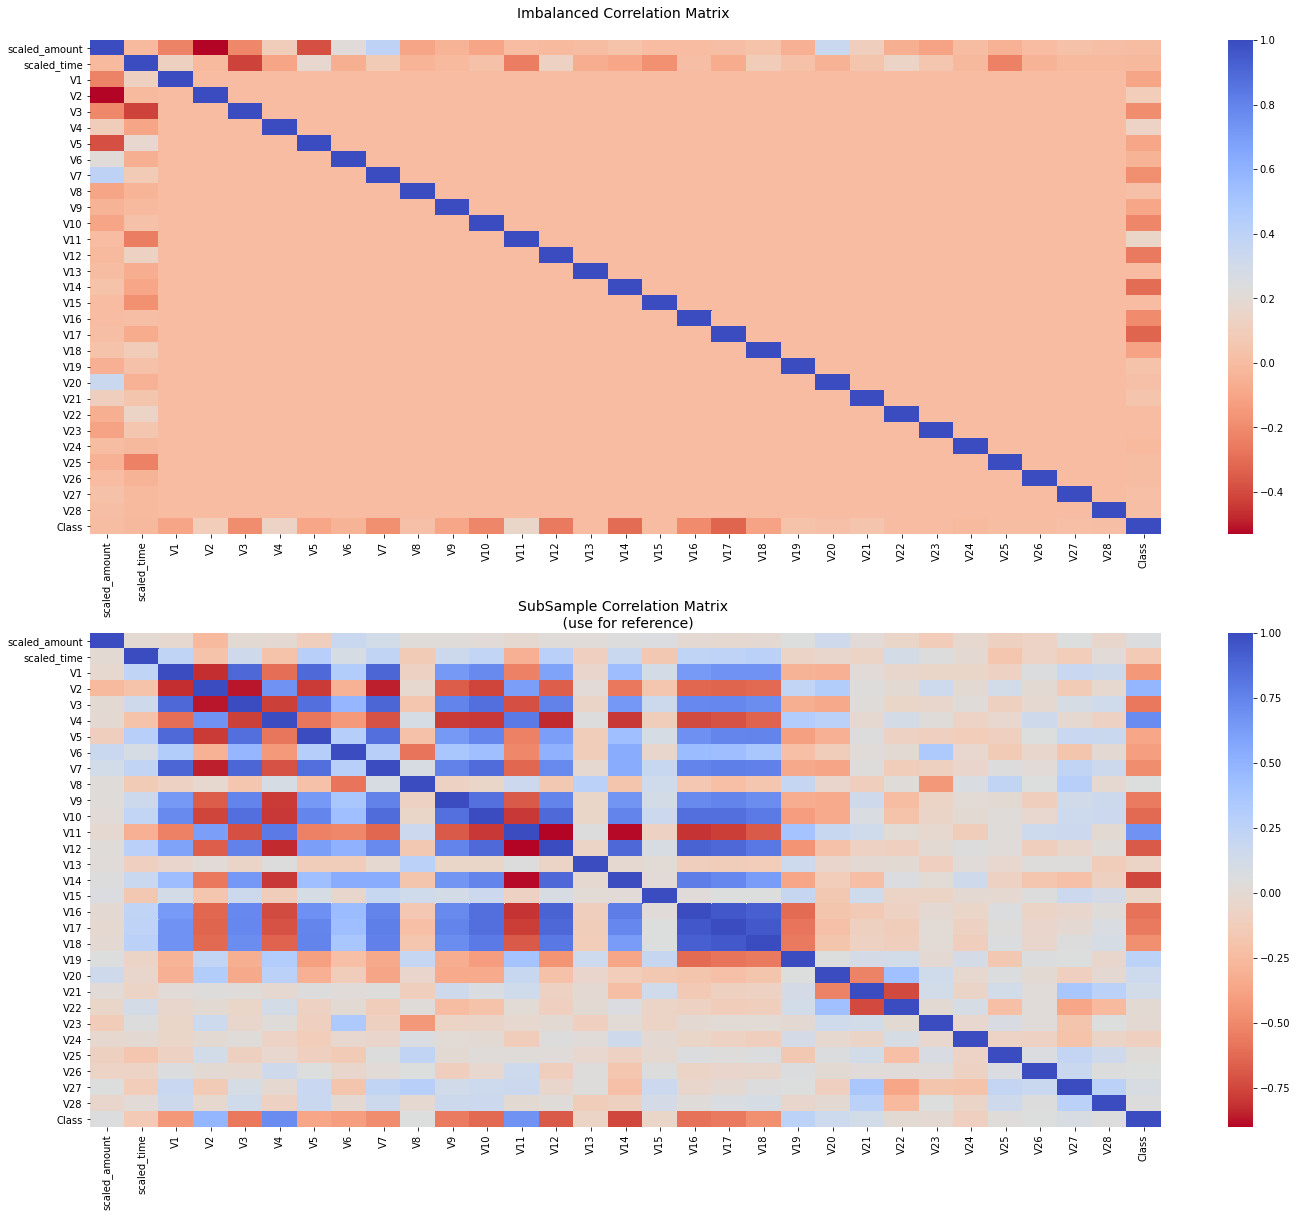

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Compute pairwise correlation of columns, excluding NA/null values
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n ", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

* V17, V14, V12 및 V10은 음의 상관 관계. 값이 낮을수록 사기 거래가 될 가능성이 높아짐


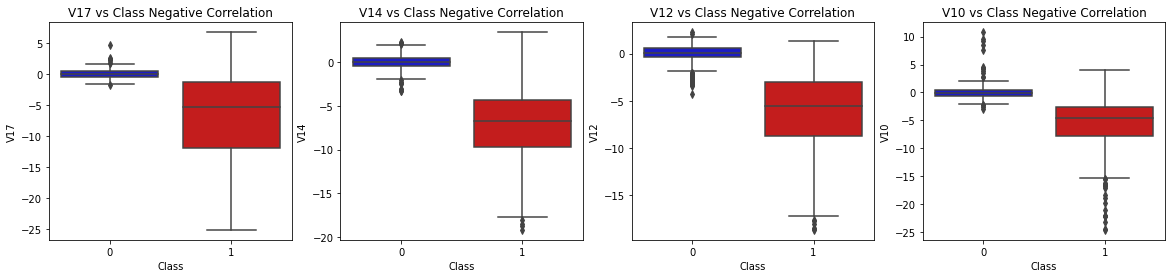

In [14]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

* V2, V4, V11 및 V19는 양의 상관 관계. 값이 클수록 사기 거래가 될 가능성이 높아짐

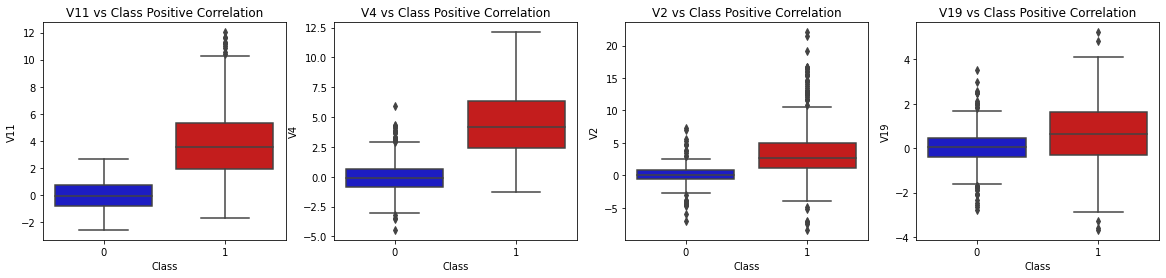

In [15]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Remove outliers
* V17, V14, V12 및 V10 컬럼 데이터에 대해 iqr 기준으로 25%미만 75%이상 값을 제거함.

In [16]:
# V14 Removing Outliers 
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# V12 removing outliers
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# V10 removing outliers
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# V17 removing outliers
v17_fraud = new_df['V17'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
v17_iqr = q75 - q25

v17_cut_off = v17_iqr * 1.5
v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
print('V17 Lower: {}'.format(v17_lower))
print('V17 Upper: {}'.format(v17_upper))
outliers = [x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('V17 outliers: {}'.format(outliers))
print('Feature V17 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V17'] > v17_upper) | (new_df['V17'] < v17_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -18.049997689859396, -18.8220867423816, -19.2143254902614]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.683714633344298, -18.047596570821604, -18.553697009645802, -18.4311310279993]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-22.1870885620007, -

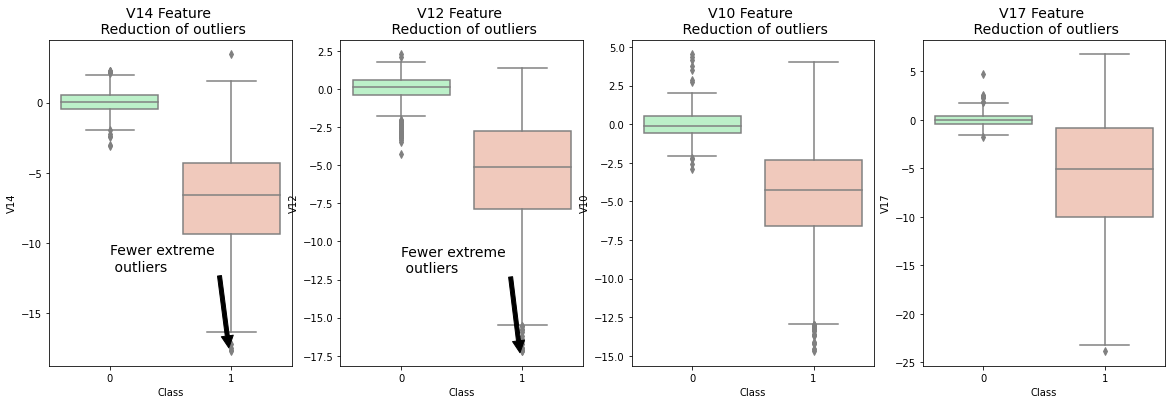

In [17]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V17
sns.boxplot(x="Class", y="V17", data=new_df, ax=ax4, palette=colors)
ax4.set_title("V17 Feature \n Reduction of outliers", fontsize=14)
#ax4.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
#            arrowprops=dict(facecolor='black'),
#            fontsize=14)

plt.show()

## Undersampling Training
* LogisticRegression, KNearest, SVM, DecsionTree, Randomforest 알고리즘 적용

In [0]:
# Cross Validation 적용전 Undersampling 
X = new_df.drop('Class', axis=1)
y = new_df['Class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Using TensorFlow backend.


Train on 602 samples, validate on 151 samples
Epoch 1/50
602/602 [==============================] - 2s 3ms/step - loss: 1.2037 - acc: 0.3854 - val_loss: 0.8606 - val_acc: 0.4570
Epoch 2/50
602/602 [==============================] - 0s 38us/step - loss: 0.7748 - acc: 0.4834 - val_loss: 0.6810 - val_acc: 0.5828
Epoch 3/50
602/602 [==============================] - 0s 48us/step - loss: 0.6229 - acc: 0.6213 - val_loss: 0.5913 - val_acc: 0.6556
Epoch 4/50
602/602 [==============================] - 0s 45us/step - loss: 0.5473 - acc: 0.7010 - val_loss: 0.5361 - val_acc: 0.7152
Epoch 5/50
602/602 [==============================] - 0s 42us/step - loss: 0.5000 - acc: 0.7492 - val_loss: 0.4974 - val_acc: 0.7616
Epoch 6/50
602/602 [==============================] - 0s 37us/step - loss: 0.4660 - acc: 0.7857 - val_loss: 0.4674 - val_acc: 0.8013
Epoch 7/50
602/602 [==============================] - 0s 38us/step - loss: 0.4384 - acc: 0.8106 - val_loss: 0.4413 - val_acc: 0.8079
Epoch 8/50
602/602 [====

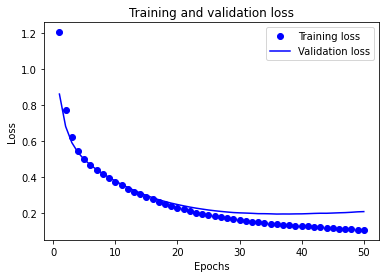

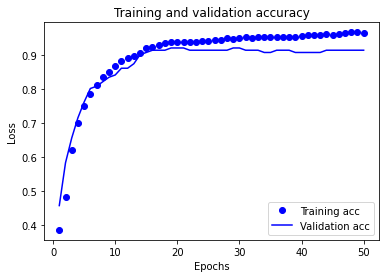

In [19]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)
history_dict = history.history

history_dict.keys()
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()

plt.show()

In [21]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

from sklearn.model_selection import cross_val_score

#cross-validation generator 5-fold cross validation

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, 
          "Has a training score of",
          round(training_score.mean(), 2) * 100,
          "% accuracy score"
          )

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 93.0 % accuracy score


## Model Parmeter tunning
* 최적의 파라미터 값을 찾기 위해 GridSerchCV()를 이용하여 최적화 수행

In [22]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# KNears best estimator
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

# Randomforest Classifier
param_grid = { 
    'n_estimators': [200, 400, 600],
    'max_features': ['auto'],
    'bootstrap': ['True']
}
grid_ran = GridSearchCV(RandomForestClassifier(), param_grid)
grid_ran.fit(X_train, y_train)
# Randomforest C best estimator
ran = grid_ran.best_estimator_
print(ran)

RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [23]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

randomforest_score = cross_val_score(ran, X_train, y_train, cv=5)
print('Randomforest Classifier Cross Validation Score', round(randomforest_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.89%
Knears Neighbors Cross Validation Score 93.09%
Support Vector Classifier Cross Validation Score 93.49%
DecisionTree Classifier Cross Validation Score 91.9%
Randomforest Classifier Cross Validation Score 93.62%


In [0]:
# Plot Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, estimator5, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # Logistic Regression
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=12)
    #ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # KNN 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=12)
    #ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # SVM
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=12)
    #ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Decison Tree
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=12)
    #ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
   

    # Random forest
    train_sizes, train_scores, test_scores = learning_curve(
        estimator5, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax5.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax5.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax5.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax5.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax5.set_title("Randomforest Learning Curve", fontsize=12)
    #ax5.set_xlabel('Training size (m)')
    ax5.set_ylabel('Score')
    ax5.grid(True)
    ax5.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

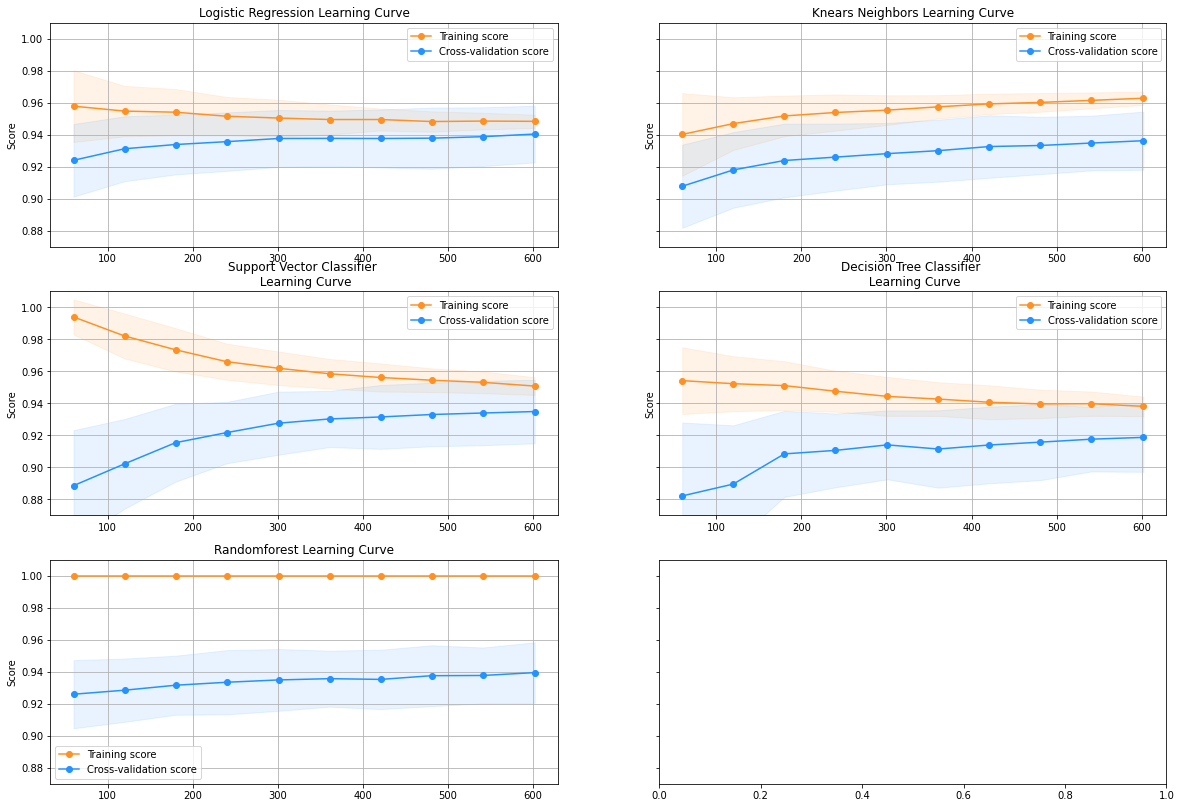

In [29]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, ran, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)



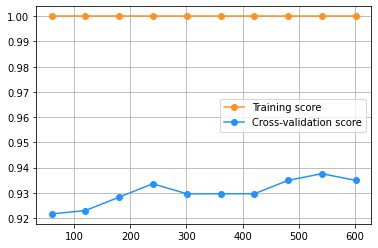

In [30]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
        ran,X_train, y_train, cv=5, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 10))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="#ff9124",
             label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="#2492ff",
             label="Cross-validation score")
#plt.set_title("Randomforest Learning Curve", fontsize=12)
    #ax6.set_xlabel('Training size (m)')
#plt.set_ylabel('Score')
plt.grid(True)
plt.legend(loc="best")
plt.show()

## SMOTE기법을 이용한 Over-Sampling

In [0]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters

for train, test in s_data.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9419834053727193
precision: 0.06081360410201967
recall: 0.9137293086660175
f1: 0.11221437801155618
---------------------------------------------------------------------------------------------------------------------------------------


In [0]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.19        98

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.59     56961
weighted avg       1.00      0.99      0.99     56961

